In [1]:
import wave
import numpy as np
import torch
from matplotlib import pyplot as plt
import glob

N_FFT = 512
SAMPLE_RATE = 16000

def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result
def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [8]:
data = glob.glob("data/speech/train/train_data/*.wav")
# datas = []
# for i in data:
#     rate, width, sig = readwav(i)
#     sig = sig.ravel()
#     datas.append(sig)

In [15]:
from scipy.io.wavfile import write
import numpy as np
import librosa
import noisereduce

def test(i):
    path = data[i]
    sig, sr = librosa.load(path, sr = 16000)
#     y = librosa.effects.trim(y=sig,top_db=10)[0]
    noise = np.random.normal(scale=0.01, size = len(sig)).astype(np.float32)
    y = sig
    librosa.output.write_wav("{}_test2.wav".format(path.split(".")[0]), y, sr)
    plt.plot(y)
    plt.show()
    print(y)
    y = noisereduce.reduce_noise(y,y[:],n_fft=512,win_length=512,hop_length=128)*3
#     y = librosa.effects.pitch_shift(y, sr, np.random.normal())
    print(y)
    librosa.output.write_wav("{}_test.wav".format(path.split(".")[0]), y, sr)

    plt.plot(sig)
    plt.show()
    plt.plot(y)
    plt.show()

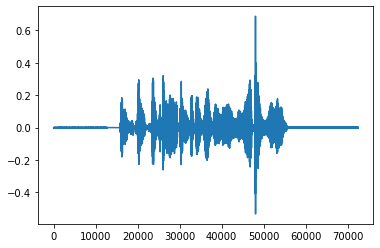

[-2.4414062e-04 -6.1035156e-05  2.4414062e-04 ...  3.0517578e-04
  5.7983398e-04  7.9345703e-04]
[-7.0412864e-04  9.7825992e-05  4.0333740e-05 ... -1.4357196e-04
 -1.0554702e-06  2.9933103e-03]


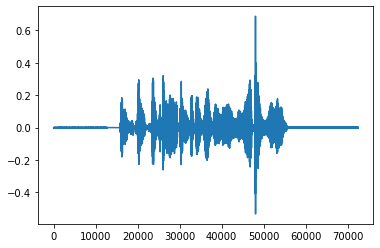

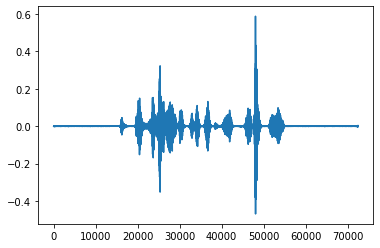

In [16]:
sig = test(5)

[-0.01094094  0.02308269  0.02371139 ...  0.00785003  0.00850858
  0.01096985]


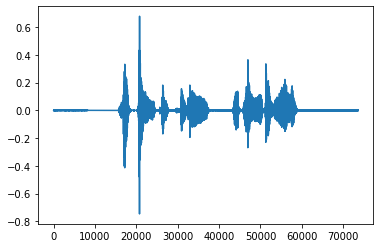

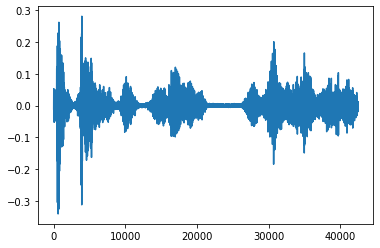

In [46]:
test(13)

In [29]:
(rate, width, sig) = readwav(path)
sig = sig.ravel()

C:\Users\POSTECH\.conda\envs\jhm\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [30]:
sig.shape

(86080,)

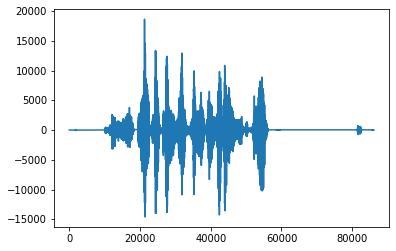

In [31]:
plt.plot(sig)

In [49]:
test = torch.stft(torch.FloatTensor(sig),
                        N_FFT,
                        hop_length=int(0.01*SAMPLE_RATE),
                        win_length=int(0.030*SAMPLE_RATE),
                        window=torch.hamming_window(int(0.030*SAMPLE_RATE)),
                        center=False,
                        normalized=False,
                        onesided=True)

In [50]:
test.shape

torch.Size([257, 535, 2])

In [17]:
def get_spectrogram_feature(filepath):
    (rate, width, sig) = readwav(filepath)
    sig = sig.ravel()

    stft = torch.stft(torch.FloatTensor(sig),
                        N_FFT,
                        hop_length=int(0.01*SAMPLE_RATE),
                        win_length=int(0.030*SAMPLE_RATE),
                        window=torch.hamming_window(int(0.030*SAMPLE_RATE)),
                        center=False,
                        normalized=False,
                        onesided=True)
    stft = (stft[:,:,0].pow(2) + stft[:,:,1].pow(2)).pow(0.5);
    amag = stft.numpy();
    feat = torch.FloatTensor(amag)
    feat = torch.FloatTensor(feat).transpose(0, 1)

    return feat

In [32]:
test = get_spectrogram_feature(path)

C:\Users\POSTECH\.conda\envs\jhm\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [33]:
test.shape

torch.Size([535, 257])

C:\Users\POSTECH\.conda\envs\jhm\lib\site-packages\matplotlib\axes\_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

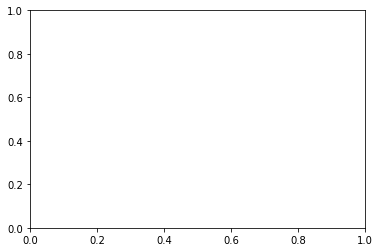

In [55]:
plt.specgram(sig)